In [45]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from missile_gym import MissileGym

In [141]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import figure, subplot2grid
# from functional import seq
from ipywidgets import interact, interactive, fixed
import ipywidgets
from math import *
# %config InlineBackend.figure_format = 'svg'

In [142]:
gym = MissileGym.make_simple_scenario((-3500, 3500), (-300, 0), missile_vel_abs=1.0)
done = False
reward = 0
obs = gym.reset()
state = gym.get_state()
history = []
alphas_targeting = []
while not done:
    rews = []
    for a in [-1,0,1]:
        obs, reward, done, info = gym.step(a)
        rews.append((a, reward))
        gym.set_state(state)
        
    if gym.missile.v > gym.target.v:
        action_parallel_guidance = gym.missile.get_action_parallel_guidance(gym.target)
    else:
        action_parallel_guidance = gym.missile.get_action_chaise_guidance(gym.target)
    if -0.5 <= action_parallel_guidance <= 0.5:
        action_parallel_guidance = 0
    elif action_parallel_guidance < -0.5:
        action_parallel_guidance = -1
    else:
        action_parallel_guidance = 1
#     if np.random.random() < 0.5:
#         action_parallel_guidance = np.random.choice([-1,0,1])
    obs, reward, done, info = gym.step(action_parallel_guidance)
    rews.append((action_parallel_guidance, reward))
    state = gym.get_state()
    history.append((state, obs, reward, done, info, rews))
    alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alphamax else copysign(gym.missile.alphamax, gym.missile.alpha_targeting))
    
#     if gym.missile.alpha < 0:
#         print(gym.missile.alpha, gym.missile._get_dydt(gym.missile.t, gym.missile.state[:-1])[3])
print(info['done_reason'])

False [-3500  3500]
[25.          0.          0.          2.35619449  0.          0.        ]
мы попали


In [143]:
%matplotlib inline

In [144]:
def get_an_atau(vel0, vel1, tau):
    g = 9.81
    vel0 = np.array(vel0)
    vel1 = np.array(vel1)
    a = (vel1-vel0)/tau - np.array([0, -g])
    a_tau = np.dot(a, vel0/np.linalg.norm(vel0)) *  vel0/np.linalg.norm(vel0)
    a_n = a - a_tau
    return copysign(np.linalg.norm(a_n)/g, np.cross(vel0, a_n)), copysign(np.linalg.norm(a_tau)/g, np.dot(a_tau, vel0))
    

In [145]:
mis_xs = []
mis_ys = []
trg_xs = []
trg_ys = []
ts = []
mis_vs = []
trg_vs = []
rewards = []
rewards_1 = []
rewards0 = []
rewards1 = []
alphas = []
trg_vels = []
mis_vels = []
Qs = []
for state, obs, reward, done, info, rews in tqdm(history):
    gym.set_state(state)
    mis_smry = gym.missile.get_summary()
    trg_smry = gym.target.get_summary()
    mis_xs.append(mis_smry['x'])
    mis_ys.append(mis_smry['y'])
    trg_xs.append(trg_smry['x'])
    trg_ys.append(trg_smry['y'])
    ts.append(mis_smry['t'])
    mis_vs.append(mis_smry['v'])
    trg_vs.append(trg_smry['v'])
    rewards.append(reward)
    av = (rews[0][1] + rews[1][1]+ rews[2][1])/3
    rewards_1.append(rews[0][1]-av)
    rewards0.append(rews[1][1]-av)
    rewards1.append(rews[2][1]-av)
    alphas.append(mis_smry['alpha'])
    Qs.append(mis_smry['Q'])
    
    trg_vels.append(gym.target.vel)
    mis_vels.append(gym.missile.vel)

trg_nys = [get_an_atau(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
trg_nys += [trg_nys[-1]]
mis_nys = [get_an_atau(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
mis_nys += [trg_nys[-1]]

trg_nxs = [get_an_atau(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
trg_nxs += [trg_nxs[-1]]
mis_nxs = [get_an_atau(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
mis_nxs += [trg_nxs[-1]]


In [146]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(history)-1,step=1, value=len(history)-1))
def draw(i):
    f0 = figure(num = 0, figsize = (17, 7))
    ax01 = subplot2grid((4, 7), (0, 0), colspan=4, rowspan=4)
    ax02 = subplot2grid((4, 7), (0, 4), colspan=3, rowspan=1)
    ax03 = subplot2grid((4, 7), (1, 4), colspan=3, rowspan=1,sharex=ax02)
    ax04 = subplot2grid((4, 7), (2, 4), colspan=3, rowspan=1,sharex=ax02)
    ax05 = subplot2grid((4, 7), (3, 4), colspan=3, rowspan=1,sharex=ax02)
    f0.subplots_adjust(hspace=0)   
    f0.subplots_adjust(wspace=0.7)  
    
#     state = history[i][0]
#     gym.set_state(state)
#     gym.render(fig=f0, ax=ax01)
    ax01.plot(mis_xs[:i], mis_ys[:i], ls=':')
    ax01.plot(trg_xs[:i], trg_ys[:i], ls=':')
    ax01.grid(True)
    
    ax02.plot(ts[:i], mis_vs[:i], label='Скорость ракеты')
    ax02.plot(ts[:i], trg_vs[:i], label='Скорость цели')
    ax02.legend()
    ax02.grid(True)
    
    ax03.plot(ts[:i], rewards[:i], label='Награда_')
    ax03.plot(ts[:i], rewards_1[:i], label='Награда-1')
    ax03.plot(ts[:i], rewards0[:i], label='Награда0')
    ax03.plot(ts[:i], rewards1[:i], label='Награда1')
#     ax03.plot(ts[:i], Qs[:i], label='Q')
    ax03.legend()
    ax03.grid(True)
    
    ax04.plot(ts[:i], alphas[:i], label=r'$\alpha_{текущий}$')
    ax04.plot(ts[:i], alphas_targeting[:i], label=r'$\alpha_{потребный}$', color='y', ls='-')
    ax04.legend()
    ax04.grid(True)
    
    ax05.plot(ts[:i], mis_nys[:i], label=r'$n_y$ ракеты', c='b')
    ax05.plot(ts[:i], trg_nys[:i], label=r'$n_y$ цели', c='orange')
    
    ax05.plot(ts[:i], mis_nxs[:i], label=r'$n_x$ ракеты', c='b', ls='--')
    ax05.plot(ts[:i], trg_nxs[:i], label=r'$n_x$ цели', c='orange', ls='--')
    ax05.legend()
    ax05.grid(True)
    
    plt.show()

interactive(children=(IntSlider(value=379, description='i', max=379), Output()), _dom_classes=('widget-interac…

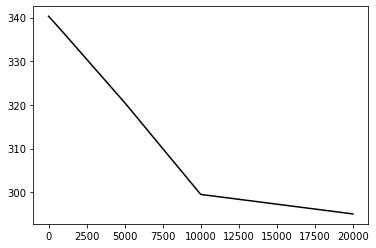

In [91]:
gym.missile.a_itr.plot()

0.44400641249999995

In [9]:
from mybot import Agent


env = MissileGym.make_simple_scenario((-1500, 500), (-200, 0), missile_vel_abs=1.0)

def action_sample_foo():
    gym = env
    if gym.missile.v > gym.target.v:
        action_parallel_guidance = gym.missile.get_action_parallel_guidance(gym.target)
    else:
        action_parallel_guidance = gym.missile.get_action_chaise_guidance(gym.target)
    if -0.5 <= action_parallel_guidance <= 0.5:
        action_parallel_guidance = 0
    elif action_parallel_guidance < -0.5:
        action_parallel_guidance = -1
    else:
        action_parallel_guidance = 1
    if np.random.random() < 0.7:
        action_parallel_guidance = np.random.choice([-1,0,1])
    return action_parallel_guidance

agent = Agent(obs.shape, 0.99, 0.999, 0.00025, 3, 100000, 64, action_sample_foo, eps_dec=0.000025)
    
# agent.load_models()

fname = 'prigress.png'

scores, eps_hist = [], []
# hl, = plt.plot(scores, eps_hist)
# def update_line():

False [-1500   500]
[25.         0.         0.         2.8198421  0.         0.       ]
Memory buffer get 17.6 MB


epsiode 0  score -62.5   avg_score -62.5   eps 0.9856  mem_cntr 600 слишком долго
epsiode 1  score -366.2   avg_score -214.4   eps 0.9784  mem_cntr 886 мы упали
epsiode 2  score -46.5   avg_score -158.4   eps 0.9634  mem_cntr 1486 слишком долго
epsiode 3  score -344.6   avg_score -204.9   eps 0.9552  mem_cntr 1814 мы упали
epsiode 4  score -78.9   avg_score -179.7   eps 0.9402  mem_cntr 2414 слишком долго
epsiode 5  score -333.3   avg_score -205.3   eps 0.9300  mem_cntr 2821 мы упали
epsiode 6  score -333.9   avg_score -223.7   eps 0.9230  mem_cntr 3102 мы упали
epsiode 7  score -112.0   avg_score -209.7   eps 0.9080  mem_cntr 3702 слишком долго
epsiode 8  score -378.6   avg_score -228.5   eps 0.9020  mem_cntr 3943 мы упали
epsiode 9  score -360.1   avg_score -241.7   eps 0.8944  mem_cntr 4246 мы упали
epsiode 10  score -96.6   avg_score -228.5   eps 0.8794  mem_cntr 4846 слишком долго
epsiode 11  score -311.1   avg_score -235.3   eps 0.8697  mem_cntr 5235 мы упали
epsiode 12  score -3

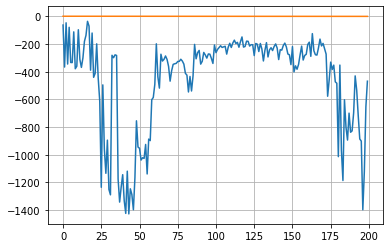

In [10]:
num_games = 200

for i in range(num_games):
    done = False
    state = env.reset()
    score = 0

    while not done:
        action = agent.choose_action(state[np.newaxis,:])
        state_, reward, done, info = env.step(action)
        score +=  reward
        agent.store_transaction(state, action+1, reward, state_, done)
        agent.learn()
        state = state_
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    print(f'epsiode {i}  score {score:.1f}   avg_score {avg_score:.1f}   eps {agent.epsilon:.4f}  mem_cntr {agent.memory.mem_cntr} {info["done_reason"]}')
    eps_hist.append(agent.epsilon)
plt.plot(scores)
plt.plot(eps_hist)
plt.grid(True)
plt.show()

In [11]:
gym = MissileGym.make_simple_scenario((-1500, 500), (-200, 0), missile_vel_abs=1.0)
done = False
reward = 0
obs = gym.reset()
state = gym.get_state()
history = []
alphas_targeting = []
while not done:    
    action_parallel_guidance = agent.choose_action(obs[np.newaxis,:])
    obs, reward, done, info = gym.step(action_parallel_guidance)
    rews.append((action_parallel_guidance, reward))
    state = gym.get_state()
    rews = [(-1,reward),(0,reward),(1,reward),(1,reward)]
    history.append((state, obs, reward, done, info, rews))
    alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alphamax else copysign(gym.missile.alphamax, gym.missile.alpha_targeting))
    
#     if gym.missile.alpha < 0:
#         print(gym.missile.alpha, gym.missile._get_dydt(gym.missile.t, gym.missile.state[:-1])[3])
print(info['done_reason'])

False [-1500   500]
[25.         0.         0.         2.8198421  0.         0.       ]
слишком долго


In [12]:
from tqdm import tqdm_notebook

In [13]:
for i in tqdm_notebook(range(10000)):
    agent.learn()

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [14]:
agent.load_models()

... loading tetris_bot_eval ....


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
np.arra